In [1]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#Import your modules
#---------------------------------------
import admin_functions as adfn
import network as netfn
# Define paths
#----------------------------------------------------------------------
Fcode = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
Fdata = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
Fdoc = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/Data2process/Project/' 
F10t2 = '/Volumes/Dominic 10tb2/Data2process/Project/'
Ftm = '/Volumes/Dominic Time Machine/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'

%load_ext autoreload
sys.version

'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

# Single LIF neuron
* python implementation of LIF model

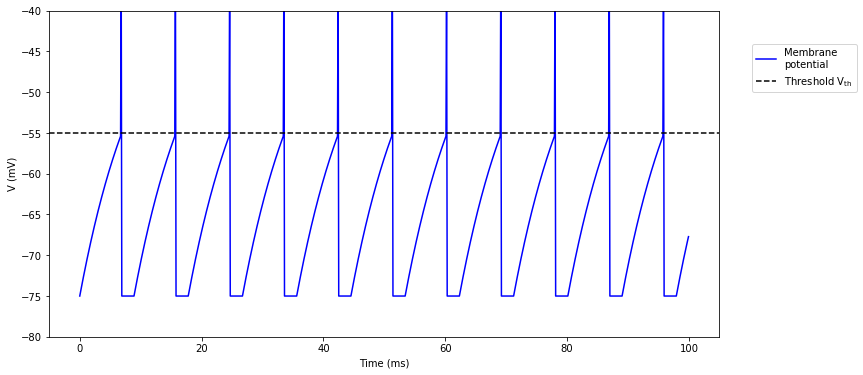

In [20]:
#LIF NEURON

#set parameters
t = 100 #simulation time
dt = 0.1 #time step
t_bins = np.arange(0, t, dt) #time bins
t_ref = 2 #refractory period
tau_m = 10 # membrane time constant - time taken to decay to 36% of max value = capacitence / leak

v_init = -75  #initial voltage
v_reset = -75 #reset voltage after spike
v_rest = -75 #equilibrium potential - resting potential

v_th = -55  #voltage spike threshold
g_L = 10 #leak 

I = 400 #input current

# Initialize voltage 
v_vec = np.zeros(len(t_bins)) #voltage values over time
v_vec[0] = v_init #voltage at time 0

# Initialize current
I = I * np.ones(len(t_bins)) #constant injected current 


# Simulate 
spike_vec = []  # record spike times
t_ref_count = 0  # the count for refractory duration

#loop through each time step
for it in range(len(t_bins) - 1):
    if t_ref_count > 0:  # check for refractoriness
        v_vec[it] = v_reset
        t_ref_count = t_ref_count - 1 #iterate until t_ref_count = 0
        
    elif v_vec[it] >= v_th:  # reset voltage and record spike event
        spike_vec.append(it)
        v_vec[it] = v_reset
        t_ref_count = t_ref / dt #convert refractory time to bins

    # calculate the increment of the membrane potential
    dv = (-1*(v_vec[it] - v_rest) + I[it] / g_L) * dt/tau_m

    # update the membrane potential
    v_vec[it+1] = v_vec[it] + dv

spike_vec = np.array(spike_vec) * dt #convert into time bins

if spike_vec.size:
    sp_num = (spike_vec / dt).astype(int) - 1
    v_vec[sp_num] += 20  # draw nicer spikes

plt.plot(t_bins, v_vec, 'b')
plt.axhline(v_th, 0, 1, color='k', ls='--')
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
         loc=[1.05, 0.75])
plt.ylim([-80, -40])
plt.show()

# LIF network
* python implementation

In [22]:
#Define net parameters
#=============================
runtime = 100 #ms
n_size = 500

net = dict()
net['weights'] = np.random.uniform(0, 1, size=(n_size, n_size)) #for neuron i (row) = weight of neuron i onto neuron j
net['delays'] = np.random.randint(11, size=(n_size, n_size)) #for neuron i (row) = delay of neuron i onto neuron j

#Define LIF parameters
#=============================
t_ref = 2 #refractory period in ms
dt = 0.1 #time step
tau_m = 10 # membrane time constant - time taken to decay to 36% of max value = capacitence / leak

v_init = -75  #initial voltage
v_reset = -75 #reset voltage after spike
v_rest = -75 #equilibrium potential - resting potential
v_th = -55  #voltage spike threshold
g_L = 1.3 #leak 


#Define later - make dynamic not constant?
#Poisson spike trains 
#random selection of neuron at a given rate, with given step size

inp_current = np.random.randint(2, size=(n_size, runtime), dtype=np.bool)
inp_current = inp_current*50 + (1-inp_current)*5 # units mV

# Initialise voltage + current + spikes
spikes = np.zeros((n_size, runtime))
v = np.ones((n_size, runtime))*v_init

delays_inv = net['delays'].T #delay of neuron j onto neuron i (current neuron of interest)
weights_inv = net['weights'].T #weight of neuron j onto neuron i (current neuron of interest)

#Loop through each time step
for t in range(runtime - 1): 
    
    #Calculate internal current (from other neurons)
    past = t - delays_inv #array with time to look back to - neuron i (row) for all incoming neuron js (columns)
    past[past < 0] = t #reset negative values to current time - no spikes assigned yet
    
    past_spikes = spikes[np.arange(n_size), past] #array of incoming spikes - neuron i (row) for all incoming neuron js (columns)
    int_current = (past_spikes*weights_inv).sum(-1) #internal current - vector sum of incoming weights onto each neuron

    #Calculate external current (from external input)
    ext_current = inp_current[:,t]
    
    #vector of total current
    I = ext_current + int_current

    #Euler's method - stepwise approximate 1ms of activity
    for d in range(int(1/dt)):
        
        #only look at non-firing neurons - if they fire, then they are on for 1 ms so dont need to update
        not_fired = np.where(spikes[:,t] == 0)[0] #indeces for non firing neurons
        
        # calculate the increment of the membrane potential
        v[not_fired, t] += dt/tau_m *(-1*(v[not_fired,t] - v_rest) + (I[not_fired]/ g_L)) 
            
        #add spike when passed threshold
        where_thresh = np.where(v[:,t] >=v_th)[0] #where any spike has occured
        spikes[where_thresh,t]  = 1
        
    v[spikes[:,t] == 1 ,t] = v_reset #change spikes to reset potential for current time frame 
    v[:,t+1] = v[:,t]  #update starting voltage for next time frame
    


In [ ]:
# Refractory period
spike_vec = []  # record spike times
t_ref_count = 0  # the count for refractory duration

#loop through each time step
for it in range(len(t_bins) - 1):
    if t_ref_count > 0:  # check for refractoriness
        v_vec[it] = v_reset
        t_ref_count = t_ref_count - 1 #iterate until t_ref_count = 0
        
    elif v_vec[it] >= v_th:  # reset voltage and record spike event
        spike_vec.append(it)
        v_vec[it] = v_reset
        t_ref_count = t_ref / dt #convert refractory time to bins


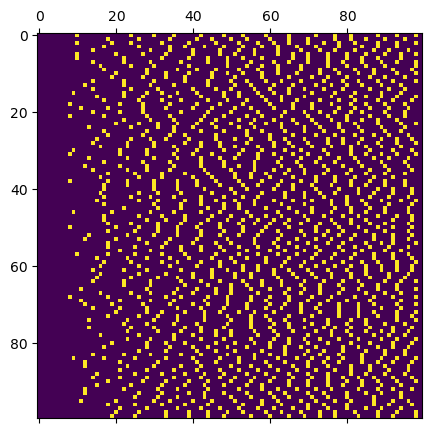

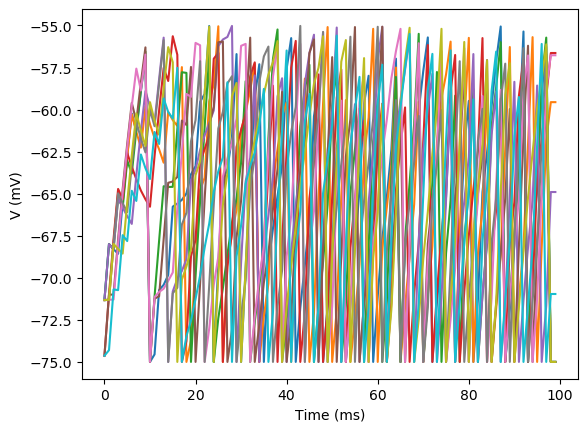

In [27]:
fig, ax = plt.subplots(figsize= (5,5))
ax.matshow(spikes[:100])
plt.show()

for i in range(10):
    plt.plot(v[i])
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
#plt.ylim([-80, -40])
plt.show()

### Tensorflow implementation

In [78]:
from __future__ import print_function
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
sess = tf.compat.v1.InteractiveSession()

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Define LIF parameters
#=============================
t_ref = 2 #refractory period in ms
dt = 0.1 #time step
tau_m = 10 # membrane time constant - time taken to decay to 36% of max value = capacitence / leak

v_init = -75  #initial voltage
v_reset = -75 #reset voltage after spike
v_rest = -75 #equilibrium potential - resting potential
v_th = -55  #voltage spike threshold
g_L = 1.3 #leak 

In [79]:
#Parameters
#=======================
n = 10 #number of neurons

# Scale of the membrane recovery (lower values lead to slow recovery)
A = np.full((n), 0.02, dtype=np.float32)

B = np.full((n), 0.2, dtype=np.float32)

C = np.full((n), -65.0, dtype=np.float32)

D = np.full((n), 8.0, dtype=np.float32)

# Spiking threshold
SPIKING_THRESHOLD = 35.0
# Resting potential
RESTING_POTENTIAL = -70.0

# Instantiate a specific tensorflow graph for the Neuron Model
graph = tf.Graph()

In [10]:
class SimpleNeurons(object):
    
    def __init__(self, n=1, A=None, B=None, C=None, D=None):

        #Parameters
        #=======================
        
        self.n = n #number of neurons

        # Scale of the membrane recovery (lower values lead to slow recovery)
        if A is None:
            self.A = np.full((n), 0.02, dtype=np.float32)
        else:
            self.A = A
        # Sensitivity of recovery towards membrane potential (higher values lead to higher firing rate)
        if B is None:
            self.B = np.full((n), 0.2, dtype=np.float32)
        else:
            self.B = B
        # Membrane voltage reset value
        if C is None:
            self.C = np.full((n), -65.0, dtype=np.float32)
        else:
            self.C = C
        # Membrane recovery 'boost' after a spike
        if D is None:
            self.D = np.full((n), 8.0, dtype=np.float32)
        else:
            self.D = D
        # Spiking threshold
        self.SPIKING_THRESHOLD = 35.0
        # Resting potential
        self.RESTING_POTENTIAL = -70.0
        
        
        
        # Instantiate a specific tensorflow graph for the Neuron Model
        self.graph = tf.Graph()
        
        ################################
        # Build the neuron model graph #
        ################################
        with self.graph.as_default():

            ##############################
            # Variables and placeholders #
            ##############################    
            self.get_vars_and_ph()
            
            ##############
            # Operations #
            ##############
            
            # Operations to evaluate the membrane response (potential v and recovery u)
            self.potential, self.recovery = self.get_response_ops()

    
    
    ###############################################
    # Define the graph Variables and placeholders #
    ###############################################
    def get_vars_and_ph(self):
        
            # Membrane potential
            # All neurons start at the resting potential
            self.v = tf.Variable(tf.constant(self.RESTING_POTENTIAL, shape=[self.n]), name='v')

            # Membrane recovery
            # All neurons start with a value of B * C
            self.u = tf.Variable(self.B*self.C, name='u')

            # We need a placeholder to pass the input current
            self.I = tf.placeholder(tf.float32, shape=[self.n])

            # We also need a placeholder to pass the length of the time interval
            self.dt = tf.placeholder(tf.float32)
            
            
            
            

    #######################################################
    # Define the graph of operations to update v and u:   # 
    # has_fired_op                                        # 
    #   -> (v_reset_op, u_rest_op)      <- I              #
    #      -> (dv_op, du_op)          <- i_op             #
    #        -> (v_op, u_op)                              #
    # We only need to return the leaf operations as their #
    # graph include the others.                           #
    #######################################################
    
    # This method for future use when we introduce synaptic currents
    def get_input_ops(self, has_fired_op, v_op):
        
        return tf.add(self.I, 0.0)
    
    

    def get_response_ops(self):

        has_fired_op, v_reset_op, u_reset_op = self.get_reset_ops()
        
        i_op = self.get_input_ops(has_fired_op, v_reset_op)
        
        v_op, u_op = self.get_update_ops(has_fired_op, v_reset_op, u_reset_op, i_op)
        
        return v_op, u_op

    def get_reset_ops(self):
        
        # Evaluate which neurons have reached the spiking threshold
        has_fired_op = tf.greater_equal(self.v, tf.constant(self.SPIKING_THRESHOLD, shape=[self.n]))
    
        # Neurons that have spiked must be reset, others simply evolve from their initial value

        # Membrane potential is reset to C
        v_reset_op = tf.where(has_fired_op, self.C, self.v)

        # Membrane recovery is increased by D 
        u_reset_op = tf.where(has_fired_op, tf.add(self.u, self.D), self.u)

        return has_fired_op, v_reset_op, u_reset_op
        
    def get_update_ops(self, has_fired_op, v_reset_op, u_reset_op, i_op):
        
        # Evaluate membrane potential increment for the considered time interval
        # dv = 0 if the neuron fired, dv = 0.04v*v + 5v + 140 + I -u otherwise
        dv_op = tf.where(has_fired_op,
                         tf.zeros(self.v.shape),
                         tf.subtract(tf.add_n([tf.multiply(tf.square(v_reset_op), 0.04),
                                               tf.multiply(v_reset_op, 5.0),
                                               tf.constant(140.0, shape=[self.n]),
                                               i_op]),
                                     self.u))
            
        # Evaluate membrane recovery decrement for the considered time interval
        # du = 0 if the neuron fired, du = a*(b*v -u) otherwise
        du_op = tf.where(has_fired_op,
                         tf.zeros([self.n]),
                         tf.multiply(self.A, tf.subtract(tf.multiply(self.B, v_reset_op), u_reset_op)))
    
        # Increment membrane potential, and clamp it to the spiking threshold
        # v += dv * dt
        v_op = tf.assign(self.v, tf.minimum(tf.constant(self.SPIKING_THRESHOLD, shape=[self.n]),
                                                 tf.add(v_reset_op, tf.multiply(dv_op, self.dt))))

        # Decrease membrane recovery
        u_op = tf.assign(self.u, tf.add(u_reset_op, tf.multiply(du_op, self.dt)))

        return v_op, u_op


In [15]:
##############
# Simulation #
##############

# Array of input current values
I_in = []
# Array of evaluated membrane potential values
v_out = []
# Duration of the simulation in ms
T = 1000
# Duration of each time step in ms
dt = 0.5
# Number of iterations = T/dt
steps = range(int(T / dt))

# Instantiate the population of neurons (here a single one)
neurons = SimpleNeurons(n=1)
    
with tf.Session(graph=neurons.graph) as sess:

    # Initialize global variables to their default values 
    sess.run(tf.global_variables_initializer())
    
    # Run the simulation at each time step
    for step in steps:
        
        t = step*dt

        # We generate a current step of 7 A between 200 and 700 ms
        if t > 200 and t < 700:
            i_in = 7.0
        else:
            i_in = 0.0
            
        # Create the dictionary of parameters to use for this time step
        feed = {neurons.I: np.full((1), i_in), neurons.dt: [dt]}
        
        # Run the neuron response operations, passing our parameters
        v, u = sess.run([neurons.potential, neurons.recovery], feed_dict=feed)
        
        # Store values
        I_in.append((t, i_in))
        v_out.append((t, v))

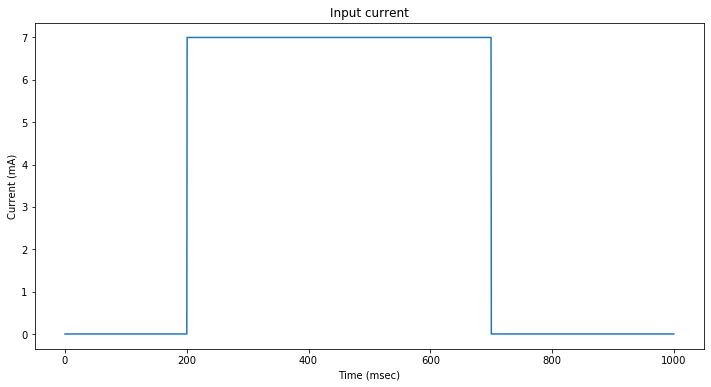

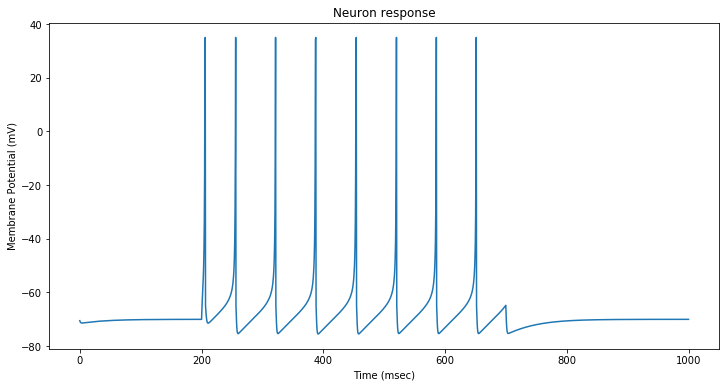

In [16]:
plt.rcParams["figure.figsize"] =(12,6)
# Draw the input current and the membrane potential
plt.figure()
plt.title('Input current')
plt.ylabel('Current (mA)')
plt.xlabel('Time (msec)')
plt.plot(*zip(*I_in))
plt.figure()
plt.title('Neuron response')
plt.ylabel('Membrane Potential (mV)')
plt.xlabel('Time (msec)')
plt.plot(*zip(*v_out))

In [12]:

# A class representing a population of simple neurons with synaptic inputs
#
class SimpleSynapticNeurons(SimpleNeurons):
    
    def __init__(self, n=1, m=100, A=None, B=None, C=None, D=None, W_in=None):
        
        # Additional model parameters
        self.m = m
        self.tau = 10.0
        if W_in is None:
            self.W_in = np.full((n,m), 0.07, dtype=np.float32)
        else:
            self.W_in = W_in
        # The reason this one is different is to allow broadcasting when subtracting v
        self.E_in = np.zeros((m), dtype=np.float32)
        
        # Call the parent contructor
        # This will call the methods we have overidden when building the graph 
        super(SimpleSynapticNeurons, self).__init__(n, A, B, C, D)
           
    ########################################################
    # Override the parent graph Variables and placeholders #
    ########################################################    
    def get_vars_and_ph(self):
        
        # Get parent grah variables and placeholders
        super(SimpleSynapticNeurons, self).get_vars_and_ph()
            
        # Input synapse conductance dynamics (increases on each synapse spike)
        self.g_in = tf.Variable(tf.zeros(dtype=tf.float32, shape=[self.m]),
                                    dtype=tf.float32,
                                    name='g_in')

        # We need a new placeholder to pass the input synapses behaviour at each timestep
        self.syn_has_spiked = tf.placeholder(tf.bool, shape=[self.m])

        
    #######################################################
    # Modify i_op in the graph of operations:             # 
    #     syn_has_spiked -> g_in_op -> i_op               #
    #######################################################
    def get_input_ops(self, has_fired_op, v_op):

        # First, update synaptic conductance dynamics:
        # - increment by one the current factor of synapses that fired
        # - decrease by tau the conductance dynamics in any case
        g_in_update_op = tf.where(self.syn_has_spiked,
                                  tf.add(self.g_in, tf.ones(shape=self.g_in.shape)),
                                  tf.subtract(self.g_in, tf.multiply(self.dt,tf.divide(self.g_in, self.tau))))

        # Update the g_in variable
        g_in_op = tf.assign(self.g_in, g_in_update_op)

        # We can now evaluate the synaptic input currents
        # Isyn = Σ w_in(j)g_in(j)E_in(j) - (Σ w_in(j)g_in(j)).v(t)
        i_op = tf.subtract(tf.einsum('nm,m->n', tf.constant(self.W_in), tf.multiply(g_in_op, tf.constant(self.E_in))),
                           tf.multiply(tf.einsum('nm,m->n', tf.constant(self.W_in), g_in_op), v_op))

        # Store a reference to this operation for easier retrieval
        self.input = i_op
        
        return i_op

In [13]:
# A class representing a population of simple neurons with synaptic inputs
#
class SimpleSynapticRecurrentNeurons(SimpleSynapticNeurons):
    
    def __init__(self, n=1, m=100, A=None, B=None, C=None, D=None, W_in=None, W=None, E=None):

        # Additional model parameters
        self.W = W
        self.E = E
        
        # Call the parent contructor
        super(SimpleSynapticRecurrentNeurons, self).__init__(n, m, A, B, C, D, W_in)

    ########################################################
    # Override the parent graph Variables and placeholders #
    ########################################################    
    def get_vars_and_ph(self):
        
        # Get parent grah variables and placeholders
        super(SimpleSynapticRecurrentNeurons, self).get_vars_and_ph()
            
        # Recurrent synapse conductance dynamics (increases on each synapse spike)
        self.g = tf.Variable(tf.zeros(dtype=tf.float32, shape=[self.n]),
                             dtype=tf.float32,
                             name='g')

    #######################################################
    # Modify i_op in the graph of operations:             # 
    #     syn_has_spiked -> i_in_op,i_rec_op -> i_op      #
    #######################################################
    def get_input_ops(self, has_fired_op, v_op):

        # First, update recurrent conductance dynamics:
        # - increment by one the current factor of synapses that fired
        # - decrease by tau the conductance dynamics in any case
        g_update_op = tf.where(has_fired_op,
                               tf.add(self.g, tf.ones(shape=self.g.shape)),
                               tf.subtract(self.g, tf.multiply(self.dt, tf.divide(self.g, self.tau))))
        
        # Update the g variable
        g_op = tf.assign(self.g, g_update_op)

        # We can now evaluate the recurrent conductance
        # I_rec = Σ wjgj(Ej -v(t))
        i_rec_op = tf.einsum('ij,j->i', tf.constant(self.W), tf.multiply(g_op, tf.subtract(tf.constant(self.E), v_op)))

        # Get the synaptic input currents from parent
        i_in_op = super(SimpleSynapticRecurrentNeurons, self).get_input_ops(has_fired_op, v_op)
        
        # The actual current is the sum of both currents
        i_op = i_in_op + i_rec_op

        # Store a reference to this operation for easier retrieval
        self.input = i_op
        
        return i_op

In [19]:
##############
# Simulation #
##############
import time
start_time = time.time()



# Duration of the simulation in ms
T = 1000
# Duration of each time step in ms
dt = 0.5
# Number of iterations = T/dt
steps = int(T / dt)
# Number of neurons
n = 8000
# Number of synapses
m = 100
# Synapses firing rate
frate = 0.002

# Array of input current values
I_in = []
# Array of evaluated membrane potential values
v_out = np.zeros((steps,n))
    
# Generate a random distribution for our neurons
p_neurons = np.random.uniform(0,1,(n))
    
# Assign neuron parameters based on the probability
a = np.full((n), 0.02, dtype=np.float32)
a[p_neurons < 0.2] = 0.1
d = np.full((n), 8.0, dtype=np.float32)
d[p_neurons < 0.2] = 2.0

# Randomly connect 10% of the neurons to the input synapses
p_syn = np.random.uniform(0,1,(n,m))
w_in = np.zeros((n,m), dtype=np.float32)
w_in[ p_syn < 0.1 ] = 0.07
    
# Randomly distribute recurrent connections
w = np.zeros((n,n),  dtype=np.float32)
p_reccur = np.random.uniform(0,1,(n,n))
w[p_reccur < 0.1] = np.random.gamma(2, 0.003, size=w[p_reccur < 0.1].shape)
# Identify inhibitory to excitatory connections (receiving end is in row)
inh_2_exc = np.ix_(p_neurons >= 0.2, p_neurons < 0.2)
# Increase the strength of these connections
w[ inh_2_exc ] = 2* w[ inh_2_exc]

# Only inhibitory neurons have E=-85 mv
e = np.zeros((n), dtype=np.float32)
e[p_neurons<0.2] = -85.0

# Instantiate the population of synaptic neurons
neurons = SimpleSynapticRecurrentNeurons(n, m, A=a, D=d, W_in=w_in, W=w, E=e)

with tf.Session(graph=neurons.graph) as sess:

    # Initialize v and u to their default values 
    sess.run(tf.global_variables_initializer())

    # Run the simulation at each time step
    for t in range(steps):
        
        # We generate random spikes on the input synapses between 200 and 700 ms
        if t * dt > 200 and t * dt < 700:
            # Generate a random matrix
            r = np.random.uniform(0,1,(m))
            # A synapse has spiked when r is lower than the spiking rate
            p_syn_spike = r < frate * dt
        else:
            # No synapse activity during that period
            p_syn_spike = np.zeros((m), dtype=bool)
        
        feed = {neurons.syn_has_spiked: p_syn_spike, neurons.dt: [dt]}

        # Run the graph corresponding to our update ops, with our parameters 
        i, v, u = sess.run([neurons.input, neurons.potential, neurons.recovery], feed_dict=feed)
        
        # Store values
        v_out[t, :] = v
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 34.58729887008667 seconds ---


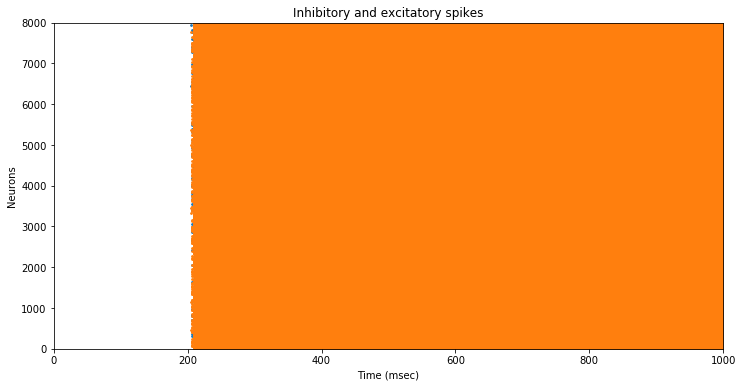

In [18]:
plt.rcParams["figure.figsize"] =(12,6)
# Split between inhibitory and excitatory
inh_v_out = np.where(p_neurons < 0.2, v_out, 0)
exc_v_out = np.where(p_neurons >= 0.2, v_out, 0)
# Identify spikes
inh_spikes = np.argwhere(inh_v_out == 35.0)
exc_spikes = np.argwhere(exc_v_out == 35.0)
# Display spikes over time
plt.axis([0, T, 0, n])
plt.title('Inhibitory and excitatory spikes')
plt.ylabel('Neurons')
plt.xlabel('Time (msec)')
# Plot inhibitory spikes
steps, neurons = inh_spikes.T
plt.scatter(steps*dt, neurons, s=3)
# Plot excitatory spikes
steps, neurons = exc_spikes.T
plt.scatter(steps*dt, neurons, s=3)